In [1]:
# https://arxiv.org/abs/cond-mat/0703314
# https://arxiv.org/abs/0808.3779

# https://github.com/scipy/scipy/issues/7151
# https://apps.dtic.mil/sti/pdfs/AD1004183.pdf
# https://www.codeproject.com/Articles/21282/Compute-Permanent-of-a-Matrix-with-Ryser-s-Algorit

# https://rosettacode.org/wiki/Determinant_and_permanent
# https://codegolf.stackexchange.com/questions/97060/calculate-the-permanent-as-quickly-as-possible

# https://stackoverflow.com/questions/38738835/generating-gray-codes
# https://qiita.com/b1ueskydragon/items/75cfee42541ea723080c

# https://qiita.com/phdax/items/3064de264c7933bab2f5
# https://web.archive.org/web/20190108235115/https://www.hackersdelight.org/hdcodetxt/pop.c.txt
# http://graphics.stanford.edu/~seander/bithacks.html#CountBitsSetParallel
# https://stackoverflow.com/questions/9829578/fast-way-of-counting-non-zero-bits-in-positive-integer

# https://stackoverflow.com/questions/22227595/convert-integer-to-binary-array-with-suitable-padding

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit
import time

In [3]:
# https://github.com/XanaduAI/thewalrus/blob/master/thewalrus/_permanent.py

@jit(nopython=True)
def perm_bbfg(M):  # pragma: no cover
    """
    Returns the permanent of a matrix using the bbfg formula in Gray ordering
    The code is a re-implementation from a Python 2 code found in
    `Permanent code golf
    <https://codegolf.stackexchange.com/questions/97060/calculate-the-permanent-as-quickly-as-possible>`_
    using Numba.
    Args:
        M (array) : a square array.
    Returns:
        float or complex: the permanent of a matrix ``M``
    """

    n = len(M)
    if n == 0:
        return M.dtype.type(1.0)
    row_comb = np.sum(M, 0)
    total = 0
    old_gray = 0
    sign = +1
    binary_power_dict = np.array([2**i for i in range(n)])
    num_loops = 2 ** (n - 1)
    for bin_index in range(1, num_loops + 1):
        reduced = np.prod(row_comb)
        total += sign * reduced
        new_gray = bin_index ^ (bin_index // 2)
        gray_diff = old_gray ^ new_gray
        gray_diff_index = np.searchsorted(binary_power_dict,gray_diff)
        new_vector = M[gray_diff_index]
        direction = 2 * ((old_gray > new_gray) - (old_gray < new_gray))
        for i in range(n):
            row_comb[i] += new_vector[i] * direction
        sign = -sign
        old_gray = new_gray
    return total / num_loops

In [4]:
@jit(nopython=True)
def calc_rsks(L):
    rs = np.arange(1,L+1) ## from 1 to L
    ks = np.linspace(np.pi/(L+1.0),L*np.pi/(L+1.0),L)
    return rs,ks

@jit(nopython=True)
def calc_eks(J,ks):
    return -2.0*J*np.cos(ks)

@jit(nopython=True)
def calc_xkrs(L,ks,rs):
    return np.sqrt(2.0/(L+1.0))*np.sin(np.outer(ks,rs))

@jit(nopython=True)
def calc_ys(t,eks,xkrs):
    xc = (1.0+0.0j)*xkrs # for numba
    expeks = np.diag(np.exp(1j*t*eks))
    return xc @ expeks @ xc

# @jit(nopython=True)
# def calc_fs(ys,system):
#     diag = (1.0+0.0j)*np.diag(system)
#     return ys @ diag @ ys.T.conjugate()

@jit(nopython=True)
def calc_fs_cdw(ys,system,period=1):
    diag = (1.0+0.0j)*np.diag(system)
    ycuts = np.copy(ys[::period,:]) ## avoid NumbaPerformanceWarning to make contiguous arrays by deep copy
#    ycuts = ys[::period,:]
    return ycuts @ diag @ ycuts.T.conjugate()

@jit(nopython=True)
def calc_z(L,system,t,eks,xkrs,period=1):
    ys = calc_ys(t,eks,xkrs)
#    fs = calc_fs(ys,system)
    fs = calc_fs_cdw(ys,system,period=period)
    dlt = np.eye(fs.shape[0],dtype=np.complex128)
    return np.vstack( (np.hstack((fs,dlt-fs)), np.hstack((dlt-fs,fs))) )

@jit(nopython=True)
def get_dat(L,system,J,ts,period=1):
    rs, ks = calc_rsks(L)
    eks = calc_eks(J,ks)
    xkrs = calc_xkrs(L,ks,rs)
    data = np.zeros((len(ts),2),dtype=np.float64)
    for i,t in enumerate(ts):
        matz = calc_z(L,system,t,eks,xkrs,period=period)
        data[i] = np.array([t,-np.log(perm_bbfg(matz).real)])
    return data

L,calctime: 4 7.496511220932007
L,calctime: 6 0.018206119537353516
L,calctime: 8 0.35466504096984863
L,calctime: 10 6.922386169433594


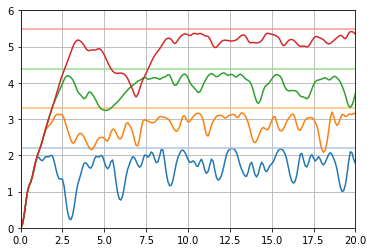

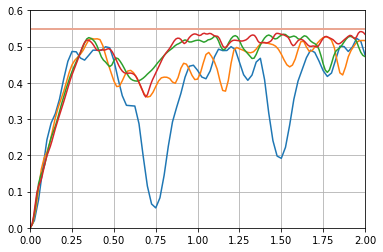

In [5]:
## Mott insulator initial

period = 1
J = 1.0
ts = np.linspace(0,20,201)
Ls = [4,6,8,10]

datas = np.zeros((len(Ls),len(ts),2),dtype=np.float64)
for i,L in enumerate(Ls):
    start = time.time()
    system = np.array([1.0 if i<L//2 else 0.0 for i in range(L)])
    datas[i] = get_dat(L,system,J,ts,period=period)
    end = time.time()
    print("L,calctime:",L,end-start)
    
cmap = plt.get_cmap("tab20")
plt.xlim(0,20)
plt.ylim(0,6)
plt.grid()
for i,L in enumerate(Ls):
    plt.plot(datas[i,:,0],datas[i,:,1],color=cmap(2*i+0))
    plt.plot([np.min(ts),np.max(ts)],[np.log(3.0)*0.5*L,np.log(3.0)*0.5*L],color=cmap(2*i+1))
plt.show()

cmap = plt.get_cmap("tab20")
plt.xlim(0,2)
plt.ylim(0,0.6)
plt.grid()
for i,L in enumerate(Ls):
    plt.plot(datas[i,:,0]/L,datas[i,:,1]/L,color=cmap(2*i+0))
    plt.plot([np.min(ts)/L,np.max(ts)/L],[np.log(3.0)*0.5,np.log(3.0)*0.5],color=cmap(2*i+1))
plt.show()

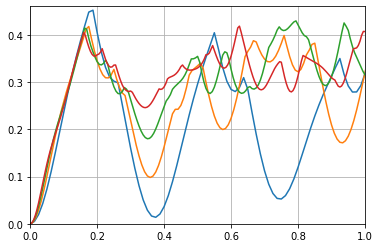

In [6]:
period = 1
J = 1.0
ts = np.linspace(0,20,201)
Ls = [4,6,8,10]

hinfs = np.zeros((len(Ls),len(ts)),dtype=np.float64)
for i,L in enumerate(Ls):
    rs, ks = calc_rsks(L)
    eks = calc_eks(J,ks)
    xkrs = calc_xkrs(L,ks,rs)
    system = np.array([1.0 if i<L//2 else 0.0 for i in range(L)])
    for j,t in enumerate(ts):
        matz = calc_z(L,system,t,eks,xkrs,period=period)
        hinfs[i,j] = np.average([np.linalg.norm(matz[:,k],ord=np.inf) for k in range(len(matz[0,:]))])

plt.xlim(0,1)
plt.grid()
for i,L in enumerate(Ls):
    plt.ylim(0,np.max(1.0-hinfs[i])*1.1)
    plt.plot(ts/(2.0*L),1.0-hinfs[i])

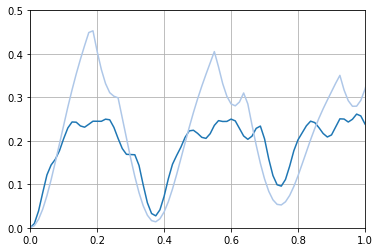

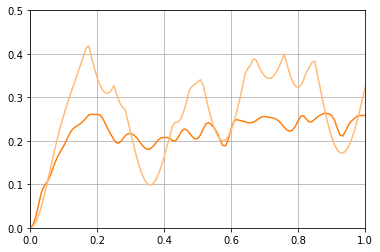

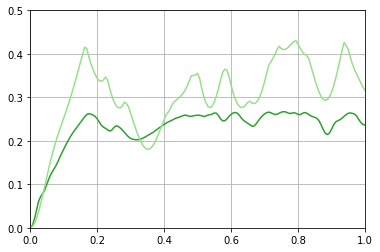

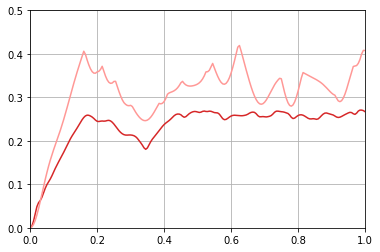

In [7]:
cmap = plt.get_cmap("tab20")
for i,L in enumerate(Ls):
    plt.xlim(0,1)
    plt.ylim(0,0.5)
    plt.grid()
    plt.plot(datas[i,:,0]/(2.0*L),datas[i,:,1]/(2.0*L),color=cmap(2*i+0))
    plt.plot(ts/(2.0*L),1.0-hinfs[i],color=cmap(2*i+1))
    plt.show()

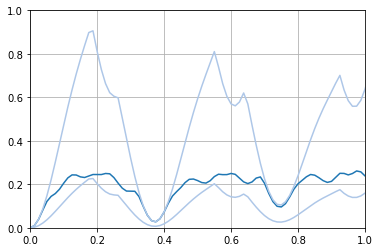

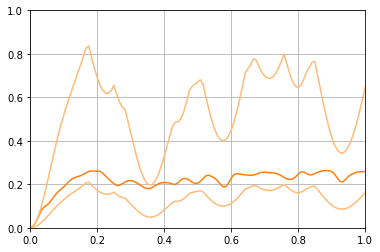

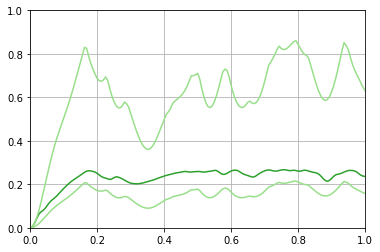

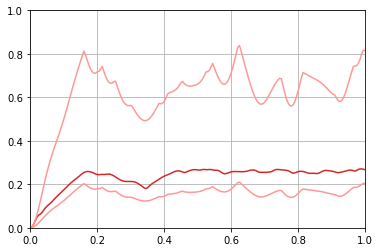

In [8]:
cmap = plt.get_cmap("tab20")
for i,L in enumerate(Ls):
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.grid()
    plt.plot(datas[i,:,0]/(2.0*L),datas[i,:,1]/(2.0*L),color=cmap(2*i+0))
    plt.plot(ts/(2.0*L),2.0*(1.0-hinfs[i]),color=cmap(2*i+1))
    plt.plot(ts/(2.0*L),0.5*(1.0-hinfs[i]),color=cmap(2*i+1))
    plt.show()

L,calctime: 4 0.0012600421905517578
L,calctime: 6 0.0014700889587402344
L,calctime: 8 0.0020971298217773438
L,calctime: 10 0.00471806526184082
L,calctime: 12 0.01770806312561035
L,calctime: 14 0.0800330638885498
L,calctime: 16 0.3451399803161621
L,calctime: 18 1.5377039909362793
L,calctime: 20 6.930945158004761


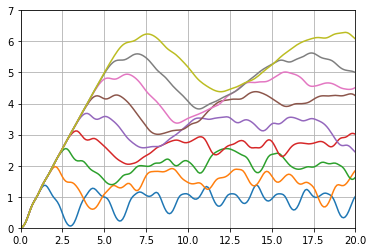

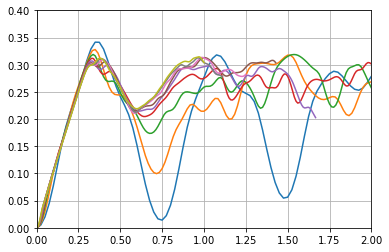

In [9]:
## CDW 010101... initial

period = 2
J = 1.0
ts = np.linspace(0,20,201)
Ls = [4,6,8,10,12,14,16,18,20]

datas = np.zeros((len(Ls),len(ts),2),dtype=np.float64)
for i,L in enumerate(Ls):
    start = time.time()
    system = np.array([1.0 if i<L//2 else 0.0 for i in range(L)])
    datas[i] = get_dat(L,system,J,ts,period=period)
    end = time.time()
    print("L,calctime:",L,end-start)
    
cmap = plt.get_cmap("tab20")
plt.xlim(0,20)
plt.ylim(0,7)
plt.grid()
for i,L in enumerate(Ls):
    plt.plot(datas[i,:,0],datas[i,:,1],color=cmap(2*i+0))
plt.show()

cmap = plt.get_cmap("tab20")
plt.xlim(0,2)
plt.ylim(0,0.4)
plt.grid()
for i,L in enumerate(Ls):
    plt.plot(datas[i,:,0]/L,datas[i,:,1]/L,color=cmap(2*i+0))
plt.show()

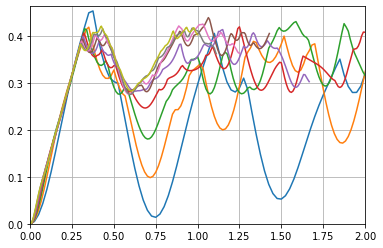

In [10]:
period = 2
J = 1.0
ts = np.linspace(0,20,201)
Ls = [4,6,8,10,12,14,16,18,20]

hinfs = np.zeros((len(Ls),len(ts)),dtype=np.float64)
for i,L in enumerate(Ls):
    rs, ks = calc_rsks(L)
    eks = calc_eks(J,ks)
    xkrs = calc_xkrs(L,ks,rs)
    system = np.array([1.0 if i<L//2 else 0.0 for i in range(L)])
    for j,t in enumerate(ts):
        matz = calc_z(L,system,t,eks,xkrs,period=period)
        hinfs[i,j] = np.average([np.linalg.norm(matz[:,k],ord=np.inf) for k in range(len(matz[0,:]))])

plt.xlim(0,2)
plt.grid()
for i,L in enumerate(Ls):
    plt.ylim(0,np.max(1.0-hinfs[i])*1.1)
    plt.plot(ts/L,1.0-hinfs[i])

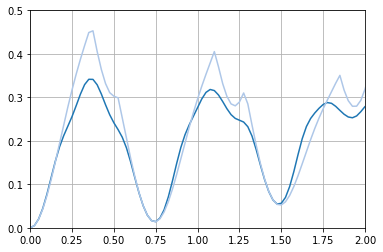

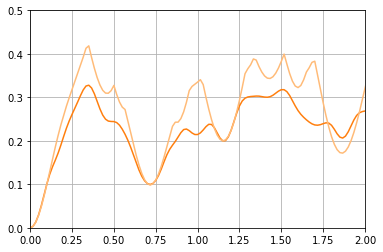

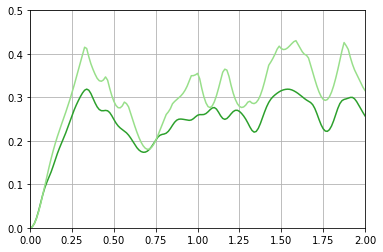

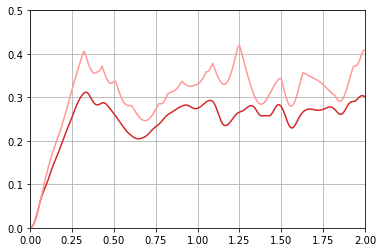

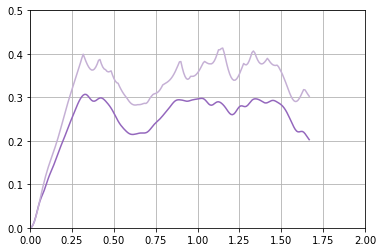

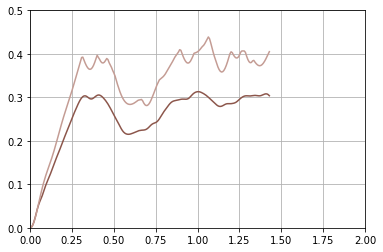

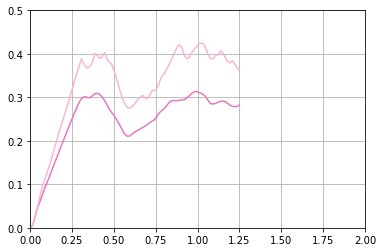

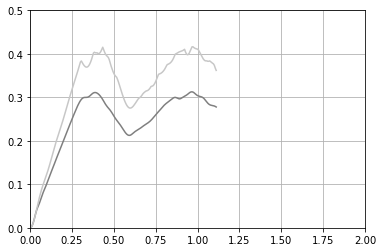

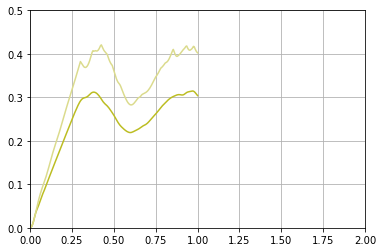

In [11]:
cmap = plt.get_cmap("tab20")
for i,L in enumerate(Ls):
    plt.xlim(0,2)
    plt.ylim(0,0.5)
    plt.grid()
    plt.plot(datas[i,:,0]/L,datas[i,:,1]/L,color=cmap(2*i+0))
    plt.plot(ts/L,1.0-hinfs[i],color=cmap(2*i+1))
    plt.show()

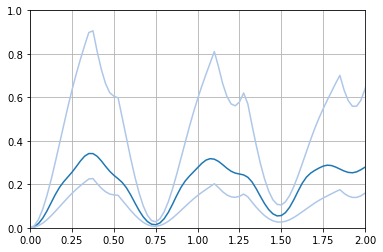

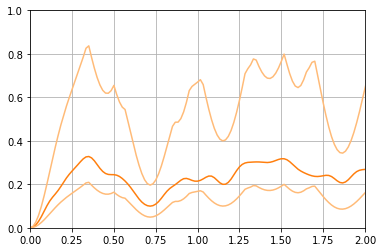

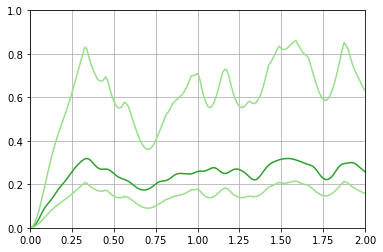

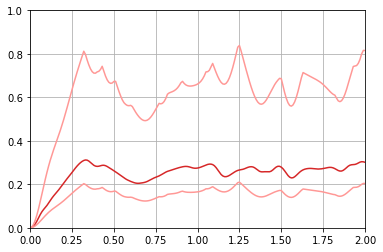

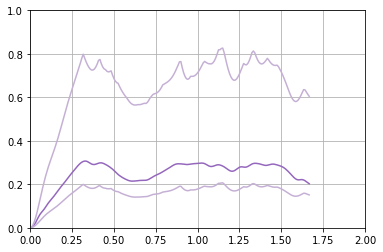

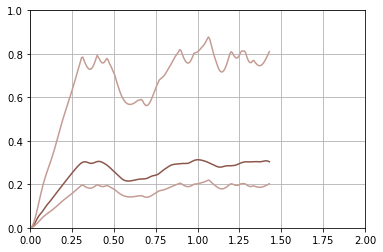

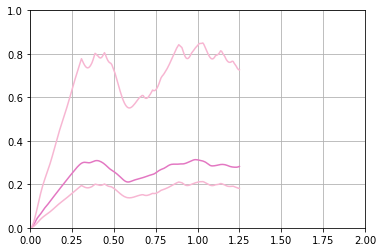

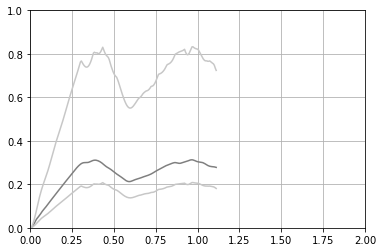

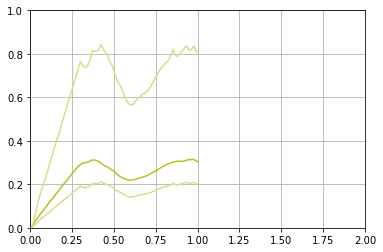

In [12]:
cmap = plt.get_cmap("tab20")
for i,L in enumerate(Ls):
    plt.xlim(0,2)
    plt.ylim(0,1)
    plt.grid()
    plt.plot(datas[i,:,0]/L,datas[i,:,1]/L,color=cmap(2*i+0))
    plt.plot(ts/L,2.0*(1.0-hinfs[i]),color=cmap(2*i+1))
    plt.plot(ts/L,0.5*(1.0-hinfs[i]),color=cmap(2*i+1))
    plt.show()